### Importing libraries

In [1]:
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
#from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import timedelta
from scipy.special import boxcox1p
from scipy import stats
import numpy as np

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Nishi_JPMC_Data/data.txt', delimiter= "|", encoding = 'unicode_escape')
# df.columns = []
df.tail()

,,variable,value
2165,2165,a,21
2166,2166,a,23
2167,2167,a,24
2168,2168,a,21
2169,2169,a,25


In [5]:
df.variable.value_counts()

score    434
h        434
i        434
w        434
a        434
Name: variable, dtype: int64

In [6]:
# Renaming Columns
vars = df.variable.unique().tolist()
vars

['score', 'h', 'i', 'w', 'a']

In [7]:
df_final = pd.DataFrame(columns = ['mother_iq', 'age', 'completed_school', 'mother_worked', 'child_iq'], index=range(434))

In [8]:
# code to convert data from loing format to wide format

cnt_score, cnt_h, cnt_i, cnt_w, cnt_a = 0,0,0,0,0

for i in range(df.shape[0]):

  if df.iloc[i,1] == 'score':
    df_final.iloc[cnt_score,4] = df.iloc[i,2]
    cnt_score +=1
  
  elif df.iloc[i,1] == 'h':
    df_final.iloc[cnt_h,2] = df.iloc[i,2]
    cnt_h +=1

  elif df.iloc[i,1] == 'i':
    df_final.iloc[cnt_i,0] = df.iloc[i,2]
    cnt_i +=1

  elif df.iloc[i,1] == 'w':
    df_final.iloc[cnt_w,3] = df.iloc[i,2]
    cnt_w +=1
  
  elif df.iloc[i,1] == 'a':
    df_final.iloc[cnt_a,1] = df.iloc[i,2]
    cnt_a +=1

df_final['mother_iq'].replace(regex=True,inplace=True, to_replace=r"'",value=r'')
df_final[['age', 'completed_school', 'mother_worked', 'child_iq']] = df_final[['age', 'completed_school', 'mother_worked', 'child_iq']].astype(int)
df_final[['mother_iq']] = df_final[['mother_iq']].astype(float)
df_final.head()

,mother_iq,age,completed_school,mother_worked,child_iq
0,121.117529,27,1,4,65
1,89.361882,25,1,4,98
2,115.443165,27,1,4,85
3,99.449639,25,1,3,83
4,92.745710,27,1,4,115


In [9]:
df_final.columns

Index(['mother_iq', 'age', 'completed_school', 'mother_worked', 'child_iq'], dtype='object')

In [10]:
df_final.dtypes

mother_iq           float64
age                   int64
completed_school      int64
mother_worked         int64
child_iq              int64
dtype: object

In [11]:
df_final.isnull().sum()

mother_iq           0
age                 0
completed_school    0
mother_worked       0
child_iq            0
dtype: int64

### EDA

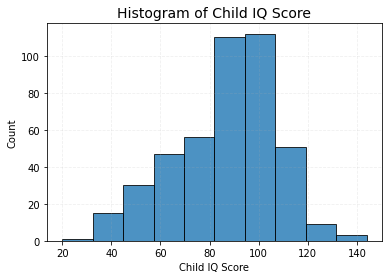

In [12]:
# checking target variable

plt.hist(df_final.child_iq, bins=10, ec="black", alpha=0.8)
plt.xlabel('Child IQ Score')
plt.ylabel('Count')
plt.title('Histogram of Child IQ Score', fontsize = 14)
plt.grid('both', linestyle='dashed', alpha=0.2)
plt.show() 

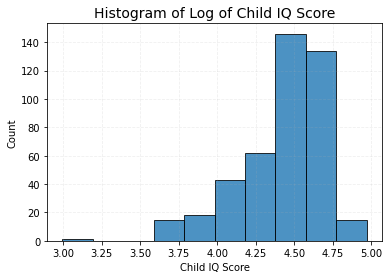

In [13]:
# checking log of target variable
df_final['log_child_iq'] = np.log(df_final.child_iq)
plt.hist(np.log(df_final.child_iq), bins=10, ec="black", alpha=0.8)
plt.xlabel('Child IQ Score')
plt.ylabel('Count')
plt.title('Histogram of Log of Child IQ Score', fontsize = 14)
plt.grid('both', linestyle='dashed', alpha=0.2)
plt.show() 

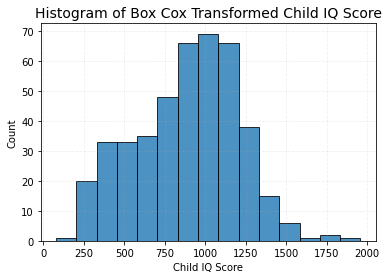

In [14]:
# checking box cox transformation of target variable

df_final['bc_child_iq'] = stats.boxcox(df_final['child_iq'])[0]

plt.hist(df_final.bc_child_iq, bins=15, ec="black", alpha=0.8)
plt.xlabel('Child IQ Score')
plt.ylabel('Count')
plt.title('Histogram of Box Cox Transformed Child IQ Score', fontsize = 14)
plt.grid('both', linestyle='dashed', alpha=0.2)
plt.show() 

In [15]:
df_final['age_*_mother_iq'] = df_final['age']*df_final['mother_iq']

In [16]:
num_features = ['mother_iq', 'age', 'completed_school']
ohe_features = ['mother_worked']

all_features = num_features + ohe_features
all_features

['mother_iq', 'age', 'completed_school', 'mother_worked']

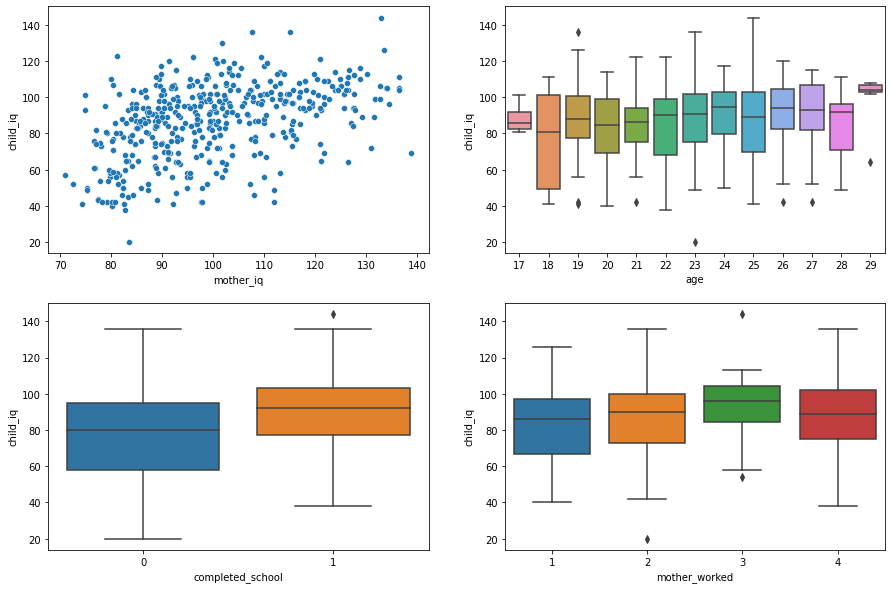

In [17]:
### Your code here
fig, ax = plt.subplots(2, 2, figsize = (15,10))
for col, subplot in zip(all_features, ax.flatten()):
    if col == 'mother_iq':
      sns.scatterplot(x=col, y=df_final['child_iq'], data = df_final[all_features] , ax= subplot)
    else:
      sns.boxplot(x=col, y=df_final['child_iq'], data = df_final[all_features] , ax= subplot)
plt.show(fig)

#### Analysis


1.   The Child's IQ and mother's IQ follow an increasingly linear relationship. As expected, they have a +ve correlation of ~0.5.
2.   Along with the hypothesis, if the mother has completed school, the Child's IQ will be higher.
3.   Age doesn't seem to have any linear relationship with the Child's IQ. However, there is high variability in the Child's IQ score for children whose mother was 18 yrs at Child's birth.
4.   There is no linear relationship between the mother's work history and the Child's IQ. Hence, will treat this variable as categorical.

### Data Types



*   Mother's iq - Numeric with Standard Scaling
*   Age - Numeric with Standard Scaling
*   Completed School - Categorical (already 1/0 Flag)
*   Mother Work History - Categorical with One Hot Encoding ( I am not using ordinal encoding as the trend is monotonically increasing or deacreasing along different categories) 



### Correlation

In [18]:
from scipy import stats
matrix = df_final[num_features + ['child_iq']].corr()
round(matrix,2)

,mother_iq,age,completed_school,child_iq
mother_iq,1.00,0.09,0.28,0.45
age,0.09,1.00,0.21,0.09
completed_school,0.28,0.21,1.00,0.24
child_iq,0.45,0.09,0.24,1.00


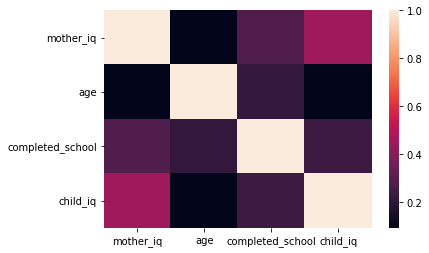

In [19]:
sns.heatmap(matrix)

In [20]:
### Adding interaction term
num_features.append('age_*_mother_iq')
num_features

all_features = num_features + ohe_features
all_features

['mother_iq', 'age', 'completed_school', 'age_*_mother_iq', 'mother_worked']

### Data Split

In [21]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [22]:
df_final_X = df_final[all_features]
df_final_y = df_final['log_child_iq']

In [23]:
df_final_X.head()

,mother_iq,age,completed_school,age_*_mother_iq,mother_worked
0,121.117529,27,1,3270.173272,4
1,89.361882,25,1,2234.047043,4
2,115.443165,27,1,3116.965452,4
3,99.449639,25,1,2486.240986,3
4,92.745710,27,1,2504.134170,4


In [24]:
df_final_X_dev, df_final_X_test, df_final_y_dev, df_final_y_test = train_test_split(df_final_X, df_final_y, test_size=0.2, random_state=0)

#### **Linear Regression with Multiple Predictors**

In [25]:
features_select = ['mother_iq', 'age', 'completed_school', 'mother_worked']

In [26]:
df_final_X_dev.head()

,mother_iq,age,completed_school,age_*_mother_iq,mother_worked
232,129.245934,26,1,3360.394274,4
423,131.533291,21,1,2762.199117,4
259,102.638887,19,1,1950.138851,4
351,84.163604,23,1,1935.762885,3
218,118.090770,22,1,2597.996935,4


In [27]:
df_final_X_dev[features_select].head()

,mother_iq,age,completed_school,mother_worked
232,129.245934,26,1,4
423,131.533291,21,1,4
259,102.638887,19,1,4
351,84.163604,23,1,3
218,118.090770,22,1,4


In [28]:
num_features = ['mother_iq', 'age', 'completed_school']
preprocess = make_column_transformer((StandardScaler(), num_features),
                                      (OneHotEncoder(handle_unknown = "ignore"), ohe_features),
                                      remainder = 'passthrough'
                                     )
pipe_lr_pure = make_pipeline(preprocess, LinearRegression())

In [29]:
def mape(pred, actual):
  mape = 0
  for (p, a) in zip(pred, actual):
     mape += abs(p-a)/a
  return mape/len(pred) 

In [30]:
pipe_fit_lr_pure = pipe_lr_pure.fit(df_final_X_dev[features_select], df_final_y_dev)

In [31]:
print(f"R2 value on Train Dataset is: { pipe_fit_lr_pure.score(df_final_X_dev[features_select], df_final_y_dev) :2f}")
print(f"R2 value on Test Dataset is: { pipe_fit_lr_pure.score(df_final_X_test[features_select], df_final_y_test) :2f}")

R2 value on Train Dataset is: 0.217263
R2 value on Test Dataset is: 0.191929


In [32]:
print(f"MAPE value on Train Dataset is: { mape(np.exp(pipe_fit_lr_pure.predict(df_final_X_dev[features_select])) , np.exp(df_final_y_dev)) :3f}")
print(f"MAPE value on Test Dataset is: { mape(np.exp(pipe_fit_lr_pure.predict(df_final_X_dev[features_select])), np.exp(df_final_y_test)) :3f}")

MAPE value on Train Dataset is: 0.198384
MAPE value on Test Dataset is: 0.060494


In [33]:
ohe_feature_names = preprocess.named_transformers_["onehotencoder"].get_feature_names().tolist()
feature_names = num_features + ohe_feature_names 
# feature_names

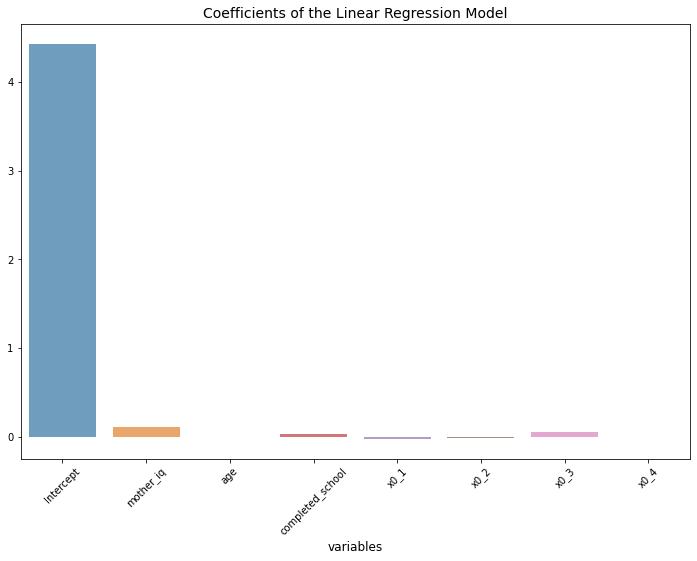

In [34]:
ceof = pipe_fit_lr_pure.named_steps['linearregression'].coef_.tolist()
intercept = pipe_fit_lr_pure.named_steps['linearregression'].intercept_.tolist()
all_coeff = [intercept] + ceof
all_coeff

all_names = ['Intercept'] + feature_names

### Your code here
plt.figure(figsize=(12,8))
ax = sns.barplot(x = all_names, y = all_coeff, alpha=0.7)
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("variables", fontsize = 12)
plt.title("Coefficients of the Linear Regression Model", fontsize=14)
#plt.plot(X_test[:,[1]].reshape(20,), ridge_yhat, color = 'red')
#sns.set_style('ticks')
plt.show(fig)

##### Tuning Elasticnet Regression for regularization

In [35]:
from sklearn.linear_model import ElasticNet

param_grid = {
              'alpha': np.linspace(0.01, 0.99, 20),
              'l1_ratio':np.linspace(0.01, 0.99, 20)
              }
param_grid

{'alpha': array([0.01      , 0.06157895, 0.11315789, 0.16473684, 0.21631579,
        0.26789474, 0.31947368, 0.37105263, 0.42263158, 0.47421053,
        0.52578947, 0.57736842, 0.62894737, 0.68052632, 0.73210526,
        0.78368421, 0.83526316, 0.88684211, 0.93842105, 0.99      ]),
 'l1_ratio': array([0.01      , 0.06157895, 0.11315789, 0.16473684, 0.21631579,
        0.26789474, 0.31947368, 0.37105263, 0.42263158, 0.47421053,
        0.52578947, 0.57736842, 0.62894737, 0.68052632, 0.73210526,
        0.78368421, 0.83526316, 0.88684211, 0.93842105, 0.99      ])}

In [36]:
pipe_lr = make_pipeline(preprocess,
                    GridSearchCV(ElasticNet(random_state=80),
                                param_grid = param_grid, cv = 10)
                    )

pipe_fit_lr = pipe_lr.fit(df_final_X_dev[features_select], df_final_y_dev)
grid_search_results_lr = pipe_lr.named_steps["gridsearchcv"]

print(f"Best Score: {grid_search_results_lr.best_score_ :3f}")
print(f"Best Parameters: {grid_search_results_lr.best_params_ }")
print(f"Performance on Test Dataset is: {pipe_lr.score(df_final_X_test, df_final_y_test) :3f}")
best_model = grid_search_results_lr.best_estimator_

Best Score: 0.112092
Best Parameters: {'alpha': 0.01, 'l1_ratio': 0.99}
Performance on Test Dataset is: 0.188594


In [37]:
print(f"R2 value on Train Dataset is: { pipe_fit_lr.score(df_final_X_dev[features_select], df_final_y_dev) :2f}")
print(f"R2 value on Test Dataset is: { pipe_fit_lr.score(df_final_X_test[features_select], df_final_y_test) :2f}")

R2 value on Train Dataset is: 0.208849
R2 value on Test Dataset is: 0.188594


In [38]:
print(f"MAPE value on Train Dataset is: { mape(np.exp(pipe_fit_lr.predict(df_final_X_dev[features_select])) , np.exp(df_final_y_dev)) :3f}")
print(f"MAPE value on Test Dataset is: { mape(np.exp(pipe_fit_lr.predict(df_final_X_dev[features_select])), np.exp(df_final_y_test)) :3f}")

MAPE value on Train Dataset is: 0.198891
MAPE value on Test Dataset is: 0.058693


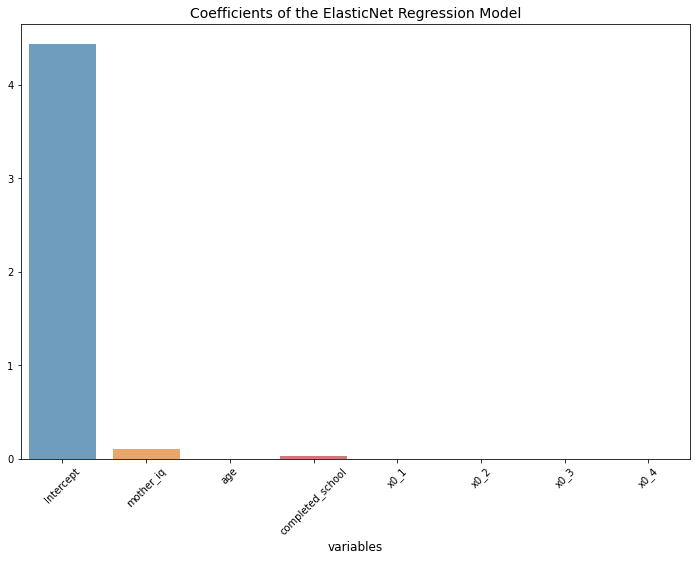

In [39]:
ceof = best_model.coef_.tolist()
intercept = best_model.intercept_.tolist()
all_coeff = [intercept] + ceof
all_coeff

all_names = ['Intercept'] + feature_names

### Your code here
plt.figure(figsize=(12,8))
ax = sns.barplot(x = all_names, y = all_coeff, alpha=0.7)
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("variables", fontsize = 12)
plt.title("Coefficients of the ElasticNet Regression Model", fontsize=14)
#plt.plot(X_test[:,[1]].reshape(20,), ridge_yhat, color = 'red')
#sns.set_style('ticks')
plt.show(fig)

The child's IQ is linearly combination of 7 independent variables and intercept (including one hot encoded) variables. Child's IQ increases for variables having +ve coefficients and vice-versa.

#### **Linear Regression with Single Predictors**

In [40]:
num_features = ['mother_iq']

In [41]:
# #code here
preprocess = make_column_transformer((StandardScaler(), num_features))
pipe_lr_pure = make_pipeline(preprocess, LinearRegression())

In [42]:
pipe_fit_lr_pure= pipe_lr_pure.fit(df_final_X_dev[num_features], df_final_y_dev)

In [43]:
print(f"R2 value on Train Dataset is: { pipe_fit_lr_pure.score(df_final_X_dev, df_final_y_dev) :2f}")
print(f"R2 value on Test Dataset is: { pipe_fit_lr_pure.score(df_final_X_test, df_final_y_test) :2f}")

R2 value on Train Dataset is: 0.195713
R2 value on Test Dataset is: 0.161276


In [44]:
print(f"MAPE value on Train Dataset is: { mape(np.exp(pipe_fit_lr_pure.predict(df_final_X_dev)) , np.exp(df_final_y_dev)) :3f}")
print(f"MAPE value on Test Dataset is: { mape(np.exp(pipe_fit_lr_pure.predict(df_final_X_dev)), np.exp(df_final_y_test)) :3f}")

MAPE value on Train Dataset is: 0.199766
MAPE value on Test Dataset is: 0.059425


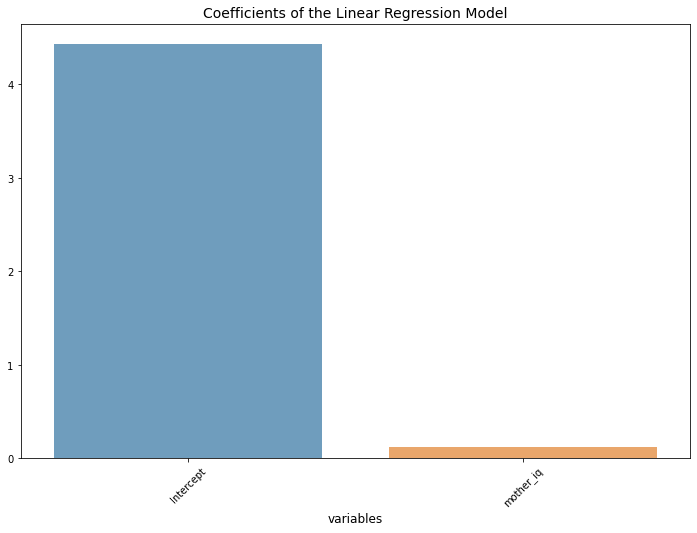

In [45]:
ceof = pipe_fit_lr_pure.named_steps['linearregression'].coef_.tolist()
intercept = pipe_fit_lr_pure.named_steps['linearregression'].intercept_.tolist()
all_coeff = [intercept] + ceof
# all_coeff

all_names = ['Intercept'] + num_features

### Your code here
plt.figure(figsize=(12,8))
ax = sns.barplot(x = all_names, y = all_coeff, alpha=0.7)
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("variables", fontsize = 12)
plt.title("Coefficients of the Linear Regression Model", fontsize=14)
#plt.plot(X_test[:,[1]].reshape(20,), ridge_yhat, color = 'red')
#sns.set_style('ticks')
plt.show(fig)

##### Tuning Elasticnet Regression for regularization

In [46]:
pipe_lr = make_pipeline(preprocess,
                    GridSearchCV(ElasticNet(random_state=80),
                                param_grid = param_grid, cv = 10)
                    )

pipe_fit_lr = pipe_lr.fit(df_final_X_dev[num_features], df_final_y_dev)
grid_search_results_lr = pipe_lr.named_steps["gridsearchcv"]

print(f"Best Score: {grid_search_results_lr.best_score_ :3f}")
print(f"Best Parameters: {grid_search_results_lr.best_params_ }")
print(f"Performance on Test Dataset is: {pipe_lr.score(df_final_X_test, df_final_y_test) :3f}")
best_model = grid_search_results_lr.best_estimator_

Best Score: 0.106307
Best Parameters: {'alpha': 0.06157894736842105, 'l1_ratio': 0.01}
Performance on Test Dataset is: 0.164162


In [47]:
print(f"R2 value on Train Dataset is: { pipe_fit_lr.score(df_final_X_dev[num_features], df_final_y_dev) :2f}")
print(f"R2 value on Test Dataset is: { pipe_fit_lr.score(df_final_X_test[num_features], df_final_y_test) :2f}")

R2 value on Train Dataset is: 0.194954
R2 value on Test Dataset is: 0.164162


In [48]:
print(f"MAPE value on Train Dataset is: { mape(np.exp(pipe_fit_lr.predict(df_final_X_dev[num_features])) , np.exp(df_final_y_dev)) :3f}")
print(f"MAPE value on Test Dataset is: { mape(np.exp(pipe_fit_lr.predict(df_final_X_dev[num_features])), np.exp(df_final_y_test)) :3f}")

MAPE value on Train Dataset is: 0.199969
MAPE value on Test Dataset is: 0.058641


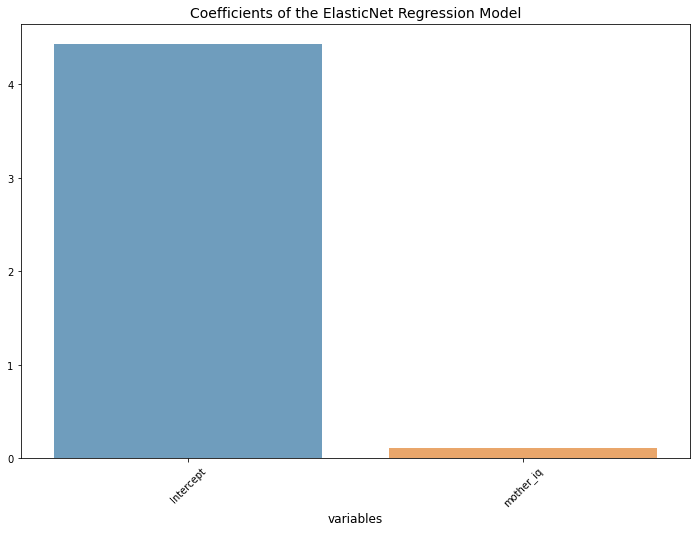

In [49]:
ceof = best_model.coef_.tolist()
intercept = best_model.intercept_.tolist()
all_coeff = [intercept] + ceof
all_coeff

all_names = ['Intercept'] + num_features

### Your code here
plt.figure(figsize=(12,8))
ax = sns.barplot(x = all_names, y = all_coeff, alpha=0.7)
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("variables", fontsize = 12)
plt.title("Coefficients of the ElasticNet Regression Model", fontsize=14)
#plt.plot(X_test[:,[1]].reshape(20,), ridge_yhat, color = 'red')
#sns.set_style('ticks')
plt.show(fig)

The child's IQ is linearly combination of intercept and Mother's IQ variables. Child's IQ increases as mother's IQ increases.

#### **Linear Regression with Mutitple Predictors (Interaction Term)**

In [50]:
num_features = ['mother_iq', 'age', 'completed_school', 'age_*_mother_iq']
ohe_features = ['mother_worked']

all_features = num_features + ohe_features
all_features

['mother_iq', 'age', 'completed_school', 'age_*_mother_iq', 'mother_worked']

In [51]:
preprocess = make_column_transformer((StandardScaler(), num_features),
                                      (OneHotEncoder(handle_unknown = "ignore"), ohe_features),
                                      remainder = 'passthrough'
                                     )
pipe_lr_pure = make_pipeline(preprocess, LinearRegression())

In [52]:
pipe_fit_lr_pure = pipe_lr_pure.fit(df_final_X_dev, df_final_y_dev)

In [53]:
print(f"R2 value on Train Dataset is: { pipe_fit_lr_pure.score(df_final_X_dev, df_final_y_dev) :2f}")
print(f"R2 value on Test Dataset is: { pipe_fit_lr_pure.score(df_final_X_test, df_final_y_test) :2f}")

R2 value on Train Dataset is: 0.224166
R2 value on Test Dataset is: 0.153670


In [54]:
print(f"MAPE value on Train Dataset is: { mape(np.exp(pipe_fit_lr_pure.predict(df_final_X_dev)) , np.exp(df_final_y_dev)) :3f}")
print(f"MAPE value on Test Dataset is: { mape(np.exp(pipe_fit_lr_pure.predict(df_final_X_test)), np.exp(df_final_y_test)) :3f}")

MAPE value on Train Dataset is: 0.198880
MAPE value on Test Dataset is: 0.200549


In [55]:
ohe_feature_names = preprocess.named_transformers_["onehotencoder"].get_feature_names().tolist()
feature_names = num_features + ohe_feature_names 
feature_names

['mother_iq',
 'age',
 'completed_school',
 'age_*_mother_iq',
 'x0_1',
 'x0_2',
 'x0_3',
 'x0_4']

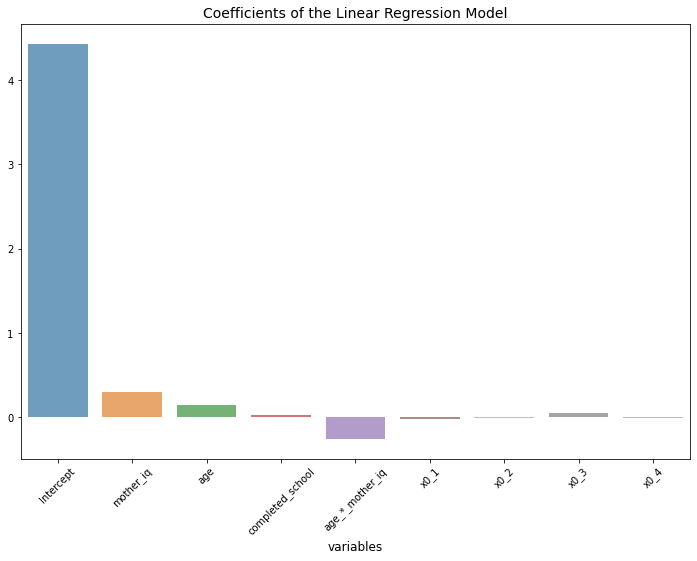

In [56]:
ceof = pipe_fit_lr_pure.named_steps['linearregression'].coef_.tolist()
intercept = pipe_fit_lr_pure.named_steps['linearregression'].intercept_.tolist()
all_coeff = [intercept] + ceof
all_coeff

all_names = ['Intercept'] + feature_names

### Your code here
plt.figure(figsize=(12,8))
ax = sns.barplot(x = all_names, y = all_coeff, alpha=0.7)
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("variables", fontsize = 12)
plt.title("Coefficients of the Linear Regression Model", fontsize=14)
#plt.plot(X_test[:,[1]].reshape(20,), ridge_yhat, color = 'red')
#sns.set_style('ticks')
plt.show(fig)

##### Tuning Elasticnet Regression for regularization

In [57]:
pipe_lr = make_pipeline(preprocess,
                    GridSearchCV(ElasticNet(random_state=80),
                                param_grid = param_grid, cv = 10)
                    )

pipe_fit_lr = pipe_lr.fit(df_final_X_dev, df_final_y_dev)
grid_search_results_lr = pipe_lr.named_steps["gridsearchcv"]

print(f"Best Score: {grid_search_results_lr.best_score_ :3f}")
print(f"Best Parameters: {grid_search_results_lr.best_params_ }")
print(f"Performance on Test Dataset is: {pipe_lr.score(df_final_X_test, df_final_y_test) :3f}")
best_model = grid_search_results_lr.best_estimator_

Best Score: 0.111816
Best Parameters: {'alpha': 0.01, 'l1_ratio': 0.99}
Performance on Test Dataset is: 0.188594


In [58]:
print(f"R2 value on Train Dataset is: { pipe_fit_lr.score(df_final_X_dev, df_final_y_dev) :2f}")
print(f"R2 value on Test Dataset is: { pipe_fit_lr.score(df_final_X_test, df_final_y_test) :2f}")

R2 value on Train Dataset is: 0.208849
R2 value on Test Dataset is: 0.188594


In [59]:
print(f"MAPE value on Train Dataset is: { mape(np.exp(pipe_fit_lr.predict(df_final_X_dev)) , np.exp(df_final_y_dev)) :3f}")
print(f"MAPE value on Test Dataset is: { mape(np.exp(pipe_fit_lr.predict(df_final_X_dev)), np.exp(df_final_y_test)) :3f}")

MAPE value on Train Dataset is: 0.198891
MAPE value on Test Dataset is: 0.058693


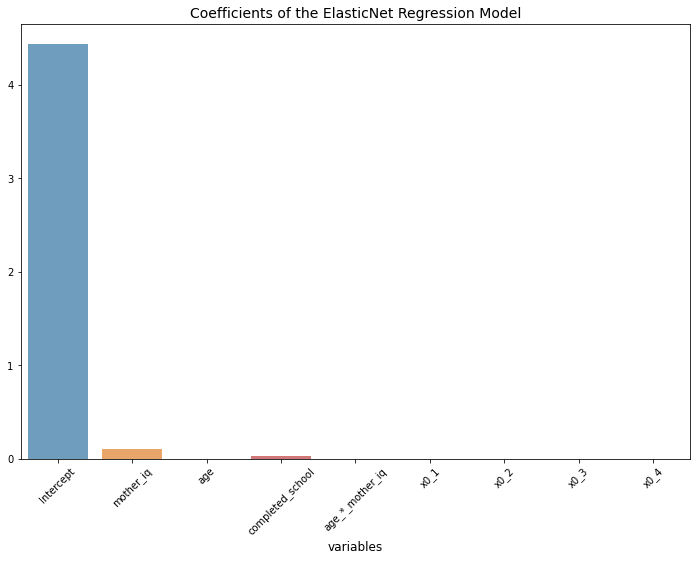

In [60]:
ceof = best_model.coef_.tolist()
intercept = best_model.intercept_.tolist()
all_coeff = [intercept] + ceof
all_coeff

all_names = ['Intercept'] + feature_names

### Your code here
plt.figure(figsize=(12,8))
ax = sns.barplot(x = all_names, y = all_coeff, alpha=0.7)
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("variables", fontsize = 12)
plt.title("Coefficients of the ElasticNet Regression Model", fontsize=14)
#plt.plot(X_test[:,[1]].reshape(20,), ridge_yhat, color = 'red')
#sns.set_style('ticks')
plt.show(fig)


The child's IQ is a linear combination of 8 independent variables and intercept (including one hot encoded) variables. Child's IQ increases for variables having +ve coefficients and vice-versa. 

The interaction term adds multicollinearity in the dataset, which violates the assumption of linear regression. This is also evident from ElasticNet, where the coefficient of the interaction time is zero.